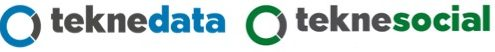


## DATA EXPLORATION

In [1]:
from os import listdir
import pandas as pd
import numpy as np

%matplotlib inline  
import matplotlib as mpl
import matplotlib.pyplot as plt

def find_csv_filenames(path_to_dir, suffix=".csv" ):
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith(suffix) ]

In [2]:
path_ine = './data/ine/'
path = './data/samples/'
path_dim = './data/samples_dim/'

csv_files = find_csv_filenames(path)
print('available files\n', csv_files)

available files
 ['81_sales_anonymized.csv', '80_sales_anonymized.csv', '36_sales.csv', '29_sales_anonymized.csv', '14_sales.csv', '30_sales_anonymized.csv', '51_sales_anonymized.csv', '7_sales.csv', '70_sales_anonymized.csv', '53_sales_anonymized.csv', '27_sales_AL1.csv']


In [3]:
df_postal_info = pd.read_csv(path_ine+'postal_info.csv', 
                                    converters={'postal_code':str,
                                                'postal_entity_name':str,
                                                'postal_municipality_id':str,
                                                'postal_municipality_name':str})
df_postal_info

,postal_code,postal_entity_name,postal_municipality_id,postal_municipality_name
0,00005,girona,17079,girona
1,00040,angeles vegas matute,40223,vegas de matute
2,00042,soria,42173,soria
3,00043,pobla de massaluca (la),43110,"pobla de massaluca, la"
4,00045,gamonal,45165,talavera de la reina
...,...,...,...,...
14753,52006,melilla,52001,melilla
14754,70702,mao,07032,maó-mahón
14755,80154,grao,12077,moncofa
14756,91319,aguda,33024,gijón


In [4]:
df_postal_code__income = pd.read_csv(path_ine+'postal_code__income.csv', 
                                     converters={'postal_code':str})
df_postal_code__income

,postal_code,income
0,11400,16147
1,11401,19389
2,11402,24967
3,11403,21902
4,11404,17069
...,...,...
571,46024,19239
572,46025,18819
573,46026,19649
574,46035,20251


In [5]:
df_postal_municipality_id__income = pd.read_csv(path_ine+'postal_municipality_id__income.csv', 
                                                converters={'postal_municipality_id':str})
df_postal_municipality_id__income

,postal_municipality_id,income
0,02,13611
1,02003,21177
2,02007,13227
3,02008,17672
4,02009,18020
...,...,...
2930,50272,20807
2931,50288,23539
2932,50297,22842
2933,50298,19847


In [6]:
for csv_file in csv_files:
    
    # Loading
    print ('preprocessing', path+csv_file)
    df_sales = pd.read_csv(path+csv_file, sep=';', dtype='unicode')

    # Preprocessing
    df_sales['ow'] = csv_file.split('_')[0]

    df_sales = pd.merge(df_sales, df_postal_info, 
                           left_on='cust_postal_code', right_on='postal_code', how='left', suffixes=('', '_duplicate'))
    
    df_sales = pd.merge(df_sales, df_postal_code__income, 
                            left_on='cust_postal_code', right_on='postal_code', how='left')
    df_sales.rename(columns={'income': 'cust_postal_code_income'}, inplace=True)

    df_sales = pd.merge(df_sales, df_postal_municipality_id__income, 
                            left_on='postal_municipality_id', right_on='postal_municipality_id', how='left')

    df_sales.rename(columns={'postal_entity_name': 'cust_postal_entity_name',
                             'postal_municipality_id': 'cust_postal_municipality_id',
                             'postal_municipality_name': 'cust_postal_municipality_name',
                             'income': 'cust_postal_municipality_income'}, inplace=True)    
    
    df_sales['cust_birth_year'] = df_sales['cust_birth_date'].str[6:10].astype(float)            
    df_sales['dim_cat__cust_accepts_communications'] = df_sales['cust_accepts_communications'] == '3'
    df_sales['dim_cat__cust_accepts_communications'] = df_sales['dim_cat__cust_accepts_communications'].astype(str)
    for i in range(1,9):
        df_sales['dim_cat__event_att0'+str(i)] = df_sales['ow_type'].astype(str) + '_' + df_sales['event_att0'+str(i)]
    
    dim_columns_cat = ['ow', 'ow_type',
                       'cust_gender', 'cust_id_grp', 'cust_postal_code', 
                       'cust_postal_entity_name', 'cust_postal_municipality_id', 'cust_postal_municipality_name',
                       'event_id', 'op_channel_name',
                       'sess_id', 'venue_name']
    for column in dim_columns_cat:
        df_sales['dim_cat__'+column] = df_sales[column].astype(str).str.lower()
        
    dim_columns_num = ['cust_birth_year', 'cust_postal_municipality_income',
                       'sale_ticketsqt', 'sale_value_base', 'sale_value_discount',
                       'sale_value_fee', 'sale_value_final',
                       'sess_capacity' ]
    for column in dim_columns_num:
        df_sales['dim_num__'+column] = df_sales[column]        

    dim_columns_date = ['op_datetime', 'sess_datetime']
    for column in dim_columns_date:
        df_sales['dim_date__'+column] = pd.to_datetime(df_sales[column]).dt.strftime('%m/%d/%Y %H:%M:%S')        


    # Storing
    df_sales[list(filter(lambda c: 'dim_' in c, list(df_sales.columns)))].to_csv(
        path_dim+csv_file, 
        index=False, 
        sep=';')  

preprocessing ./data/samples/81_sales_anonymized.csv
preprocessing ./data/samples/80_sales_anonymized.csv
preprocessing ./data/samples/36_sales.csv
preprocessing ./data/samples/29_sales_anonymized.csv
preprocessing ./data/samples/14_sales.csv
preprocessing ./data/samples/30_sales_anonymized.csv
preprocessing ./data/samples/51_sales_anonymized.csv
preprocessing ./data/samples/7_sales.csv
preprocessing ./data/samples/70_sales_anonymized.csv
preprocessing ./data/samples/53_sales_anonymized.csv
preprocessing ./data/samples/27_sales_AL1.csv


In [7]:
print (0/0)

ZeroDivisionError: division by zero

### CATEGORICAL DIMENSIONS

In [ ]:
threshold = 0.01

dim_cat = ['dim_cat__ow', 'dim_cat__ow_type',
           'dim_cat__cust_id_grp', 'dim_cat__cust_gender', 'dim_cat__cust_accepts_communications', 
           'dim_cat__cust_postal_code', 'dim_cat__cust_postal_municipality_name', 'dim_cat__cust_postal_municipality_id', 'dim_cat__cust_postal_entity_name',
           #'dim_cat__event_att01', 'dim_cat__event_att02', 'dim_cat__event_att03', 'dim_cat__event_att04', 
           #'dim_cat__event_att05', 'dim_cat__event_att06', 'dim_cat__event_att07', 'dim_cat__event_att08', 
           'dim_cat__event_id',
           'dim_cat__op_channel_name',
           'dim_cat__sess_id',
           'dim_cat__venue_name']

for dimension in dim_cat:
    print ('Plotting', dimension)
    dim_type = dimension.split('__')[0]
    for csv_file in csv_files:
        plt.figure(figsize=(20,3))
        try:
            df_sales = pd.read_csv(path_dim+csv_file, sep=';', dtype='unicode')    
            freq = df_sales[dimension].value_counts()
            prob = df_sales[dimension].value_counts(normalize=True)            
            mask = prob > threshold
            tail_freq = freq.loc[~mask].sum()
            freq = freq.loc[mask]
            if tail_freq>0:
                freq['other'] = tail_freq
            freq.plot(kind='bar', label=csv_file)
            plt.legend()
            plt.xticks(rotation=25)        
            plt.ylabel(dimension.split('__')[1])
            plt.title(dimension.split('__')[1] + ': ' + csv_file)
            plt.show()
        except:
            print(dimension, csv_file)
    print ('\n\n\n')        

### NUMERICAL DIMENSIONS

In [ ]:
dim_num = ['dim_num__cust_birth_year', 'dim_num__cust_postal_municipality_income',
           'dim_num__sale_value_final', 'dim_num__sale_value_fee', 
           'dim_num__sale_value_discount', 'dim_num__sale_value_base', 'dim_num__sale_ticketsqt', 
           'dim_num__sess_capacity']
for dimension in dim_num:
    print ('Plotting', dimension)
    for csv_file in csv_files:
        plt.figure()
        df_sales = pd.read_csv(path_dim+csv_file, sep=';')   
        df_sales.hist(column=dimension, figsize=(20,3), label=csv_file)
        plt.show()
    print ('\n\n\n')    

### DATE DIMENSIONS

In [ ]:
dim_date = ['dim_date__op_datetime', 'dim_date__sess_datetime']
for dimension in dim_date:
    print ('Plotting', dimension)
    plt.figure(figsize=(20,10))
    for csv_file in csv_files:
        try:
            df_sales = pd.read_csv(path_dim+csv_file, sep=';', dtype='unicode')    
            freq = pd.to_datetime(df_sales[dimension]).value_counts()        
            freq.plot(label=csv_file)
        except:
            print(dimension, csv_file)        
    plt.ylabel(dimension.split('__')[1])
    plt.title(dimension.split('__')[1])
    plt.legend()
    plt.show()
        
    print ('\n\n\n')    